# Model Architecture Point of Interest Experiments

Initial setup:

In [2]:
import os

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

In [3]:
from constants import RETRAIN_MODEL
from data import get_dataset
from information_gain import calculate_information_gains
from model_structures import ModelClasses, CNNModel
from trainer import train_model, make_model


In [4]:
def init():
    print(f'TensorFlow version: {tf.__version__}')
    tf.config.run_functions_eagerly(True)

In [5]:
init()

TensorFlow version: 2.11.0


In [6]:
train_ds, test_ds = get_dataset()

In [7]:
def get_trained_model(model_cls):
    model, trained = make_model(model_cls)
    if RETRAIN_MODEL or not trained:
        train_model(model, train_ds, test_ds)
    return model

In [8]:
for model_cls in ModelClasses:
    if not os.path.isfile(f'./data/{model_cls.__name__.lower()}_info_gain_matrix.npy'):
        print(f'Running {model_cls.__name__.lower()}')
        model = get_trained_model(model_cls)
        info_gain_matrix = calculate_information_gains(model, test_ds)
        with open(f'./data/{model_cls.__name__.lower()}_info_gain_matrix.npy', 'wb') as f:
            np.save(f, info_gain_matrix)
    else:
        print(f'File for {model_cls.__name__.lower()} already exists')

File for cnnmodel already exists
File for cnnmodel2 already exists
File for densemodel already exists


In [9]:
def load_info_gain_matrix(model_cls):
    return np.load(f'./data/{model_cls.__name__.lower()}_info_gain_matrix.npy')

info_gain_matricies = [load_info_gain_matrix(model_cls) for model_cls in ModelClasses]

Information Gain Saliency Maps


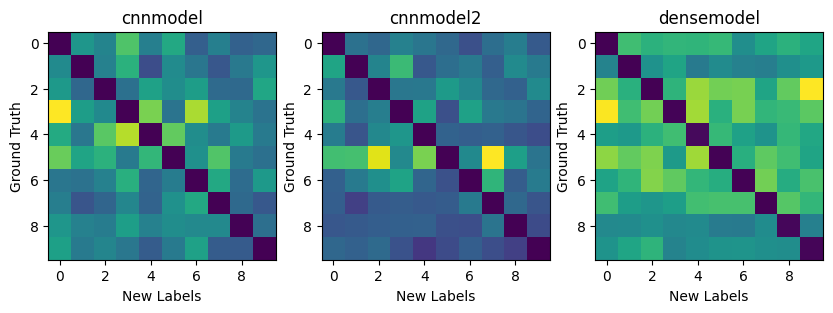

In [17]:
fig, axes = plt.subplots(1, len(ModelClasses), figsize=(10, 10))

for i in range(len(ModelClasses)):
    axes[i].imshow(info_gain_matricies[i])
    axes[i].set_title(f'{ModelClasses[i].__name__.lower()}')
    axes[i].set_xlabel('New Labels')
    axes[i].set_ylabel('Ground Truth')

print('Information Gain Saliency Maps')